In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import sklearn.metrics as skm
from sklearn import preprocessing as prep
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

import pickle

# Set True for Hyperparameter tuning. Default is False for time saving reasons
TUNING = False

In [2]:
## Load data

pickle_in = open("..\data\X_train.p", "rb")
X_train = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("..\data\y_train.p", "rb")
y_train = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("..\data\X_test.p", "rb")
X_test = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("..\data\y_test.p", "rb")
y_test = pickle.load(pickle_in)
pickle_in.close()

## Modelling
This note book bases on ```1-data_understanding_preparation.ipynb```.  
  
Now we test the following models: Lnear SVM, Random Forests and Gradient Boosted Tree Classifier.

In [4]:
# metrics

def validation(model, X_train, y_train):
    model.fit(X_train, y_train)
    skm.plot_confusion_matrix(model, X_train, y_train)
    skm.plot_roc_curve(model, X_train, y_train)
    return {'Balanced Accuracy': cross_val_score(model, X_train, y_train, scoring='balanced_accuracy').mean(),
            'Average Precision': cross_val_score(model, X_train, y_train, scoring='average_precision').mean(),
            "F1               ": cross_val_score(model, X_train, y_train, scoring='f1').mean(),
            "Roc AUC          ": cross_val_score(model, X_train, y_train, scoring='roc_auc').mean()
           }

Train and tune three different models: Linear support vector machine for classification (LinearSVC), Random Forests and Gradient Boosted Tree. After comparing the tree results on the training set, I evaluate the best set on the test set.

### SVM

In [5]:
# Hyperparameters tuning

if TUNING:
     param_grid = {"penalty": ['l1', 'l2'],
               "tol": [1e-5, 1e-4, 1e-2, 1e-1, 1],
               "C": [0.1, 1, 10, 100, 1000]
               }

     rsc = GridSearchCV(LinearSVC(random_state=123, dual=False, fit_intercept=False, max_iter=3000),\
          param_grid, n_jobs=-1, scoring='f1', verbose=1)
     rsc.fit(X_train, y_train)
     print(rsc.best_params_)

Balanced Accuracy 0.7692472080212218
Average Precision 0.8340625438786059
F1                0.7834345783776195
Roc AUC           0.8531587374886964


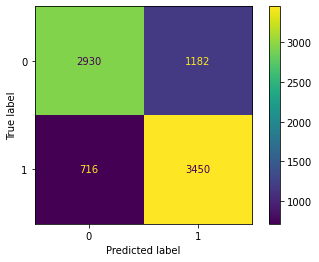

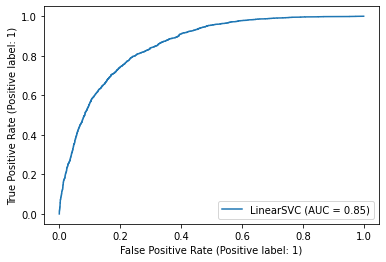

In [6]:
# test tuned hyperparameters
svc_tuned = LinearSVC(random_state=123, dual=False, fit_intercept=False, max_iter=3000, tol=.01, penalty='l2', C=0.1)

svc_performance = validation(svc_tuned, X_train, y_train)
for entry in svc_performance:
    print(entry, svc_performance[entry])

### Random Forests

In [7]:
## Hyperparameter tuning

if TUNING:
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    criterion_list = ["gini", "entropy"]
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap, 
                'criterion': criterion_list}

    clf = RandomizedSearchCV(RandomForestClassifier(random_state=123), random_grid, n_jobs=-1, scoring='f1', verbose=1, random_state=123)
    clf.fit(X_train, y_train)
    print(clf.best_params_)

In [8]:
rafo = RandomForestClassifier(
 n_estimators= 600,
 min_samples_split= 2,
 min_samples_leaf= 2,
 max_features= 'sqrt',
 max_depth= 20,
 bootstrap=False,
 criterion="entropy",
 random_state=123)

performance_rafo = validation(rafo, X_train, y_train)
for entry in performance_rafo:
    print(entry, performance_rafo[entry])

KeyboardInterrupt: 

### Gradient Boosted Tree Classifier

In [8]:
## Hyperparameter tuning

if TUNING:
    param_grid = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],
                'n_estimators':[100,250,500,750,1000,1250,1500,1750],
                'max_depth':[2,3,4,5,6,7],
                'min_samples_split':[2,4,6,8,10,20,40,60,100], 
                'min_samples_leaf':[1,3,5,7,9],
                'max_features':[2,3,4,5,6,7, "auto"],
                'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
    }
    clf = RandomizedSearchCV(GradientBoostingClassifier(random_state=123), param_grid, scoring='f1', verbose=1, random_state=123)
    clf.fit(X_train, y_train)
    print(clf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'subsample': 0.7, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 2, 'max_depth': 7, 'learning_rate': 0.1}


Balanced Accuracy 0.8292826836549094
Average Precision 0.8758980196404451
F1                0.8339429075554232
Roc AUC           0.8983696758290535


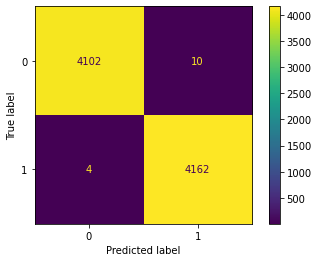

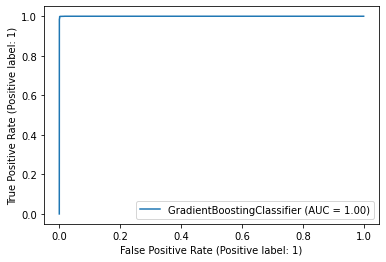

In [16]:
gbc = GradientBoostingClassifier(
    random_state=123, 
    subsample=0.7,
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=1, 
    max_features=2,
    max_depth=7,
    learning_rate=0.1,
)

performance_gbc = validation(gbc, X_train, y_train)
for entry in performance_gbc:
    print(entry, performance_gbc[entry])

## The best model
Plot the metrics to compare the thre models.  
As you can see, the linear SVM performed best. So we will evaluate this model on the test-set.

(0.8, 0.95)

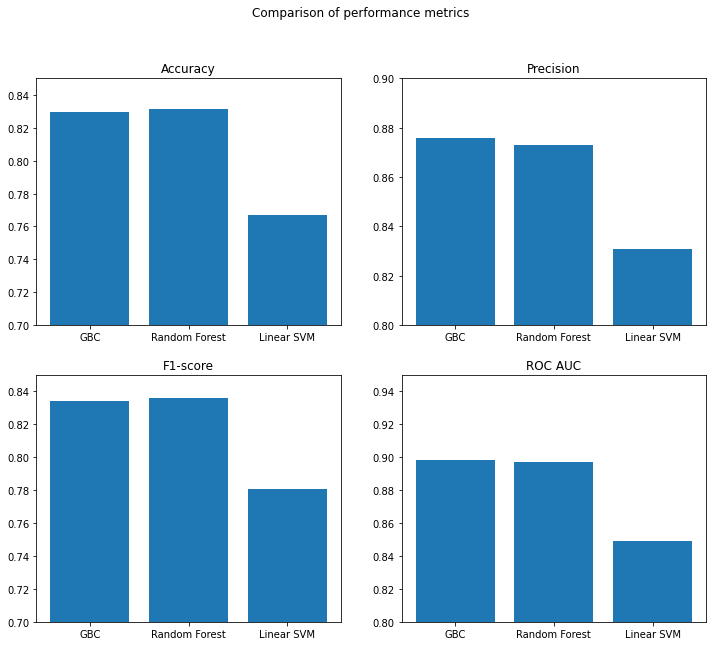

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
fig.suptitle("Comparison of performance metrics")

xs = ["GBC", "Random Forest", "Linear SVM"]

acc_list = []
prec_list = []
f1_list = []
roc_list = []

for dct in [performance_gbc, performance_rafo, svc_performance]:
    acc_list.append(dct["Balanced Accuracy"])
    prec_list.append(dct["Average Precision"])
    f1_list.append(dct["F1               "])
    roc_list.append(dct["Roc AUC          "])


ax1.bar(xs, height=acc_list)
ax1.set_title("Accuracy")
ax1.set_ylim(0.7, 0.85)

ax2.bar(xs, height=prec_list)
ax2.set_title("Precision")
ax2.set_ylim(0.8, 0.9)

ax3.bar(xs, height=f1_list)
ax3.set_title("F1-score")
ax3.set_ylim(0.7, 0.85)

ax4.bar(xs, height=roc_list)
ax4.set_title("ROC AUC")
ax4.set_ylim(0.8, 0.95)

## Evaluation
For me in this scenario precision is most important, that's why I will evaluate Gradient Boosted Tree Classifier further with test set.

Balanced Accuracy 0.8374781409739036
Precision 0.8229066410009624
F1 0.8353688324377136
ROC AUC 0.8374781409739036


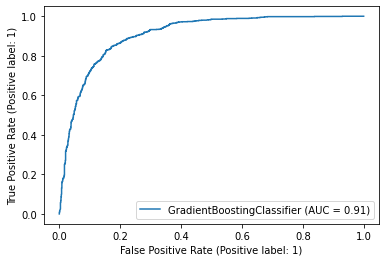

In [22]:
# Evaluate Gradient Boosted Tree
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

print("Balanced Accuracy", skm.balanced_accuracy_score(y_test, y_pred_gbc))
print("Precision", skm.precision_score(y_test, y_pred_gbc))
print("F1", skm.f1_score(y_test, y_pred_gbc))
print("ROC AUC", skm.roc_auc_score(y_test, y_pred_gbc))

skm.plot_roc_curve(gbc, X_test, y_test)
 
